# Analyzing scaling with mass 
Nov 24, 2021 \
Venkitesh Ayyar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [2]:
%matplotlib widget

In [3]:
from ipywidgets import *
from scipy import fftpack
from matplotlib.colors import LogNorm, PowerNorm, Normalize

In [4]:
# Load data
def f_get_data(fname):
    arr=np.loadtxt(fname,delimiter=',',dtype=str)
    arr_iters=arr[:,0].astype(int) # First element is iteration number
    arr1=arr[:,1:-1].astype(float)  # Skip last element (null string) and first (iteration)
    del(arr)
    # print(arr1.shape)
    L=int(np.sqrt(arr1.shape[1])) # Get lattice size
    num=arr1.shape[0]
    print(L)
    # a3=arr1.reshape(134,L,L) :  simple reshape doesn't do it in the correct order
    ## Reshape to 2D image
    arr2=np.empty((num,L,L),dtype=float)
    for i in range(num): 
        for x in range(L):
            for y in range(L):
                arr2[i,x,y]=arr1[i,x+y*L]

    print(arr2.shape)
    
    return arr2


def f_rescale(arr,mean):
    a1=np.array([np.abs((i-mean)) for i in arr])
    # a1=np.array([np.abs((i-mean))/(np.ones(mean.shape)*5) for i in arr])    
    return a1

   
# f_rescale(arr_lst[0][:5],soln)

In [5]:
# def f_spectrum(arr):
#     F2 = fftpack.fft2((arr))
#     # F2 = fftpack.fftshift(F2)
    
#     ### Absolute value of F-transform
#     F2 = np.abs(F2)**2
    
#     return F2 

def f_spectrum(arr):
    F2 = np.fft.fft2(arr)
    F2=np.fft.fftshift(F2,axes=None)
    ### Absolute value of F-transform
    F2 = np.abs(F2)**2
    
    return F2 

def f_batch_spectrum(arr):
    P_k=[f_spectrum(i) for i in arr]
    return np.array(P_k)



In [6]:
# fname='../results_phi.txt'
# fname='../results_residue.txt'
# a1=f_get_data(fname)

In [7]:
arr_type='phi'
# arr_type='residue'
# lst=['0_gs_1itr','0b_jc','1_lvl2-1itr','2_lvl4-1itr']
lst=['1_lvl2-1itr','2_lvl4-1itr','3_ntl_2lvl-1itr','4_ntl_1lvl-1itr','5_ntl_2lvl_1copy','6_ntl_2lvl_2copy','7_ntl_2lvl_3copy']
lst=['1_lvl2-1itr','3_ntl_2lvl-1itr','5_ntl_2lvl_1copy','6_ntl_2lvl_2copy','7_ntl_2lvl_3copy','8_ntl_2lvl_4copy']
lst=['1_lvl2-1itr','lvl2_quad1','lvl2_quad2','lvl2_quad3','lvl2_quad4']
lst=['1_lvl2-1itr','3_ntl_2lvl-1itr','ntl_1copy','ntl_2copy','ntl_3copy','ntl_4copy']
lst=['1_lvl2-1itr','ntl_1copy','ntl_2copy','ntl_3copy','ntl_4copy']
lst=['lvl2_tl','lvl2_1copy','lvl2_2copy','lvl2_3copy','lvl2_4copy']
lst2=['results_{0}_{1}.txt'.format(arr_type,i) for i in lst]

num=len(lst)
arr_lst=[]
for i in range(num):     
    fname='../'+lst2[i]
    # fname='../stored_results/2_32_0.04_ntl/'+lst2[i]
    print(fname)
    arr_lst.append(f_get_data(fname))

../results_phi_lvl2_tl.txt
64
(461, 64, 64)
../results_phi_lvl2_1copy.txt
64
(461, 64, 64)
../results_phi_lvl2_2copy.txt
64
(323, 64, 64)
../results_phi_lvl2_3copy.txt
64
(259, 64, 64)
../results_phi_lvl2_4copy.txt
64
(221, 64, 64)


In [8]:
labels_lst=['gs','jc','mg_2levels','mg_4levels']
labels_lst=['mg_2levels','mg_4levels','non-tele_2levels','non-tele_1level','non-tele_1copy','non-tele_2copy','non-tele_3copy']
labels_lst=['mg_2levels','non-tele_2levels','non-tele_1copy','non-tele_2copy','non-tele_3copy','non-tele_4copy']
labels_lst=['1_lvl2-1itr','lvl2_quad1','lvl2_quad2','lvl2_quad3','lvl2_quad4']
labels_lst=['mg_2levels','non-tele_2levels','non-tele_1copy','non-tele_2copy','non-tele_3copy','non-tele_4copy']
# labels_lst=['non-tele_2levels','non-tele_3copy','non-tele_4copy']
labels_lst=['a','b','c','d','e']


In [470]:
# arr_type='phi'
# # arr_type='residue'
# lst=['1_gs','1_jc','2_mg-1level1itr','3_mg-1level5itr','4_mg-4level5itr']
# lst2=['stored_results/2_32_0.04_gs/'+'results_{0}_{1}.txt'.format(arr_type,i) for i in lst]

# num=len(lst)
# arr_lst=[]
# for i in range(num):     
#     fname='../'+lst2[i]
#     print(fname)
#     arr_lst.append(f_get_data(fname))

In [9]:
# Convert phi to error
err_lst=[]
soln=arr_lst[0][-1] ## Pick best solution
for i,arr in enumerate(arr_lst):
    print(i,arr.shape)
    err_lst.append(f_rescale(arr_lst[i],soln))


0 (461, 64, 64)
1 (461, 64, 64)
2 (323, 64, 64)
3 (259, 64, 64)
4 (221, 64, 64)


In [10]:
## Compute spectrum
aspec_lst=[f_batch_spectrum(arr)[:] for arr in err_lst]

In [473]:
# k=16
# print(arr_lst[0][-1,k,k],arr_lst[1][-1,k,k],arr_lst[2][-1,k,k],arr_lst[3][-1,k,k])
# print(err_lst[0][-1,k,k],err_lst[1][-1,k,k],err_lst[2][-1,k,k],err_lst[3][-1,k,k])

### Debug single run

#### Convergence of spectral values

In [11]:
def f_plot_spec_iteration(arr,kx,ky):
    L=arr.shape[-1]
    id_x,id_y=kx+L//2,ky+L//2
    plt.figure()
    plt.plot(arr[1:,id_x,id_y]/np.max(arr[1:,id_x,id_y]),marker='o',linestyle='')
    plt.xlabel('Iteration')
    plt.yscale('log')
    plt.show()
# f_plot_spec_iteration(aspec_lst[0],0,0)

kmax=aspec_lst[0].shape[1]//2
interact(f_plot_spec_iteration,arr=fixed(aspec_lst[0]),kx=IntSlider(min=-kmax,max=kmax-1,step=1),ky=IntSlider(min=-kmax,max=kmax-1,step=1))



interactive(children=(IntSlider(value=0, description='kx', max=31, min=-32), IntSlider(value=0, description='k…

<function __main__.f_plot_spec_iteration(arr, kx, ky)>

error = (phi - solution) \
FFT of $ error[x,y] \rightarrow error[kx,ky] $ \
Plotting : $$ \frac{\mbox{error}[iter, kx, ky]}{max(\mbox{error}[iter,kx,ky])} $$ 

(461, 64, 64)


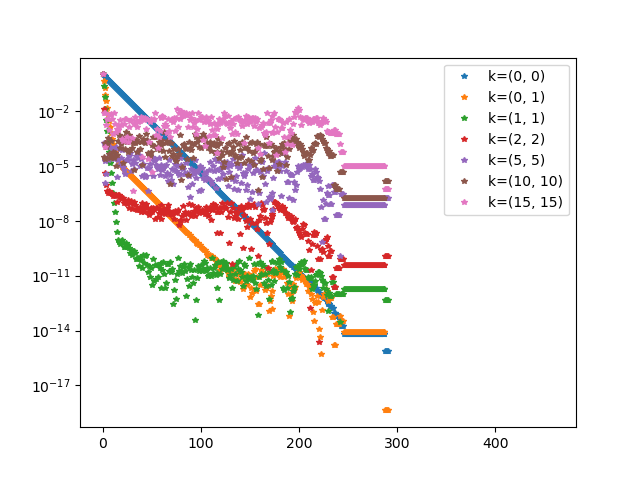

In [12]:
def f_grid_iter_plot(arr,klist):
    
    fig=plt.figure()

    size=len(klist)
    cols=max(size//2,1)
    cols=min(cols,4)
    rows=int(np.ceil(size/cols))
    # rows,cols=2,2
    
    L=arr.shape[-1]
    print(arr.shape)
    # arr=arr[:]/np.max(arr)
    for count,k in enumerate(klist):
        kx,ky=k[0],k[1]
        id_x,id_y=kx+L//2,ky+L//2
        # fig.add_subplot(rows,cols,count+1)
        # plt.plot(arr[1:,id_x,id_y], marker='*',markersize=4,linestyle='',label="k="+str(k))
        plt.plot(arr[1:,id_x,id_y]/np.max(arr[1:,id_x,id_y]), marker='*',markersize=4,linestyle='',label="k="+str(k))
        plt.legend()
        plt.yscale('log')
    plt.show()

klist=[(0,0),(0,1),(1,1),(2,2),(5,5),(10,10),(15,15)]
f_grid_iter_plot(aspec_lst[0][:5000],klist)


Slopes: 

0 : (1-0.56)/600 : 0.0008
1 : (1-5e-6)/600 : 0.002
2 : (1-3e-4)/200 : 0.005
3 : (1-1e-5)/75 :  0.013
4 : (1-6e-6)/10  : 0.1

### Compare different runs

In [17]:
# # Plot mean absolute error
# def f_plot_mean_err(arrlist,labellist):
#     fig=plt.figure()
        
#     mrkrs=['o','*','v','x','H','D','H','s','8','p']
#     for count,(lbl,mrkr) in enumerate(zip(labellist,mrkrs)):
#         arr=arrlist[count]
#         ans=np.mean(arr,axis=(1,2))
#         plt.plot(ans, marker=mrkr,markersize=5,linestyle='',label=lbl)

#         plt.legend()
#     plt.yscale('log')
#     plt.title('Mean of error')
#     plt.show()

# f_plot_mean_err(err_lst[:],labels_lst[:])

In [15]:
# Plot Spectral coefficients
def f_compare_runs(arrlist,labellist,kx,ky):
    fig=plt.figure()

    size=len(labellist)
    cols=max(size//2,1)
    cols=min(cols,4)
    rows=int(np.ceil(size/cols))
    # rows,cols=2,2
    
    L=arr.shape[-1]
    id_x,id_y=kx+L//2,ky+L//2
        
    mrkrs=['o','*','v','x','H','D','H','s','8','p']
    for count,(lbl,mrkr) in enumerate(zip(labellist,mrkrs)):
        a_spec=arrlist[count]
        # fig.add_subplot(rows,cols,count+1)
        plt.plot(a_spec[1:,id_x,id_y], marker=mrkr,markersize=5,linestyle='',label=lbl)

        plt.legend()
    plt.yscale('log')
    plt.title('Fourier coefficient of Error for kx=%s, ky=%s'%(kx,ky))
    plt.show()
    
# f_compare_runs(aspec_lst[:],labels_lst[:],2,0)

In [16]:
kmax=arr_lst[0].shape[-1]//2

interact(f_compare_runs,arrlist=fixed(aspec_lst[:]),labellist=fixed(labels_lst[:]),kx=IntSlider(min=-kmax,max=kmax-1,step=1),ky=IntSlider(min=-kmax,max=kmax-1,step=1))


interactive(children=(IntSlider(value=0, description='kx', max=31, min=-32), IntSlider(value=0, description='k…

<function __main__.f_compare_runs(arrlist, labellist, kx, ky)>

### Spectrum
$$ \lambda = m^2 + 4 \sin ^2 \left( {\frac{\pi}{L} \ k_x }\right) + 4 \sin ^2 \left( {\frac{\pi}{L} \ k_y }\right) $$ 

In [19]:
def f_lambda(kx,ky,m,L):
    return (m**2+4*(np.sin(np.pi*kx/(1.0*L)))**2+4*(np.sin(np.pi*ky/(1.0*L)))**2)

In [21]:
m=0.04;L=64
# plt.figure()
# x=np.arange(-L/2,L/2)
# y=f_lambda(x,0,m,L)
# plt.plot(x,y,linestyle='',marker='*')

#### Dataframe for spectrum

In [22]:
df_list=[]

for j in range(len(err_lst)): 
    arr_0=err_lst[j]
    cols=['iter','kx','ky','Lambda','C']
    df1=pd.DataFrame(columns=cols)
    a_spec=f_batch_spectrum(arr_0)
    arr=a_spec[:]
    print(arr.shape)
    size=int(arr_0.shape[-1])
    dict1={}
    ilist=[1,2,3,4,5,20,100,500,1000,3000,4999]
    ### ilist=np.arange(arr.shape[0])
    iter_list=[i for i in ilist if i<arr.shape[0]]
    L=arr_0.shape[-1]    
    for itr in iter_list:
        if itr<arr.shape[0]:
            for kx in range(-size//2,size//2):
                for ky in range(-size//2,size//2):
                    id_x,id_y=kx+L//2,ky+L//2
                    vals=[itr,kx,ky,f_lambda(kx,ky,m,L),arr[itr,id_x,id_y]]
                    dict1=dict(zip(cols,vals))
                    # print(dict1)
                    df1=df1.append(dict1,ignore_index=True)
            # print('iter',itr)
    df1=df1.sort_values(by=['iter','Lambda','kx','ky'])
    print(df1.shape,itr)
    df_list.append(df1)


(461, 64, 64)
(28672, 5) 100
(461, 64, 64)


KeyboardInterrupt: 

In [ ]:
len(err_lst),len(df_list)

In [189]:
df1=df_list[2]
print(iter_list)
df1

[1, 2, 3, 4, 5, 20]


,iter,kx,ky,Lambda,C
528,1.0,0.0,0.0,0.001600,23414.135268
496,1.0,-1.0,0.0,0.040029,15.522905
527,1.0,0.0,-1.0,0.040029,15.522905
529,1.0,0.0,1.0,0.040029,15.522905
560,1.0,1.0,0.0,0.040029,15.522905
...,...,...,...,...,...
8193,1000.0,-16.0,-15.0,7.963171,0.000000
8223,1000.0,-16.0,15.0,7.963171,0.000000
8224,1000.0,-15.0,-16.0,7.963171,0.000000
9184,1000.0,15.0,-16.0,7.963171,0.000000


Text(0.5, 0, '$\\lambda$')

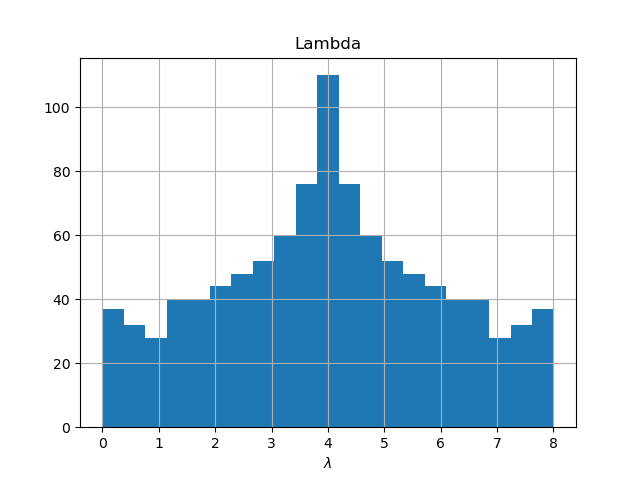

In [190]:
## Spectrum histogram
df=df1[df1.iter==1]
df.hist(column='Lambda',bins=21)
plt.xlabel('$\lambda$')

Text(0.5, 1.0, 'Fourier coefficients for Full spectrum')

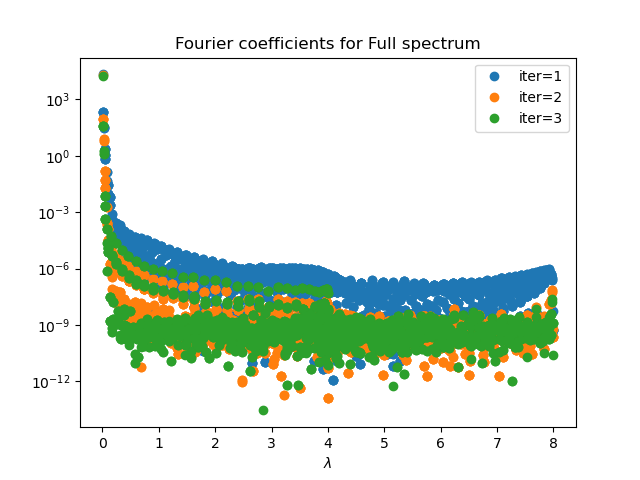

In [23]:
# Variation of fourier coefficients vs spectrum 
iter_list=np.unique(df1.iter.values).astype(int)
plt.figure()
for itr in iter_list:
    df=df1[df1.iter==itr]
    plt.plot(df.Lambda,df.C,linestyle='',marker='o',label='iter='+str(itr))
plt.legend()
plt.yscale('log')
plt.xlabel('$\lambda$')
plt.title('Fourier coefficients for Full spectrum')

In [192]:
np.unique(df.iter.values)

array([1000.])

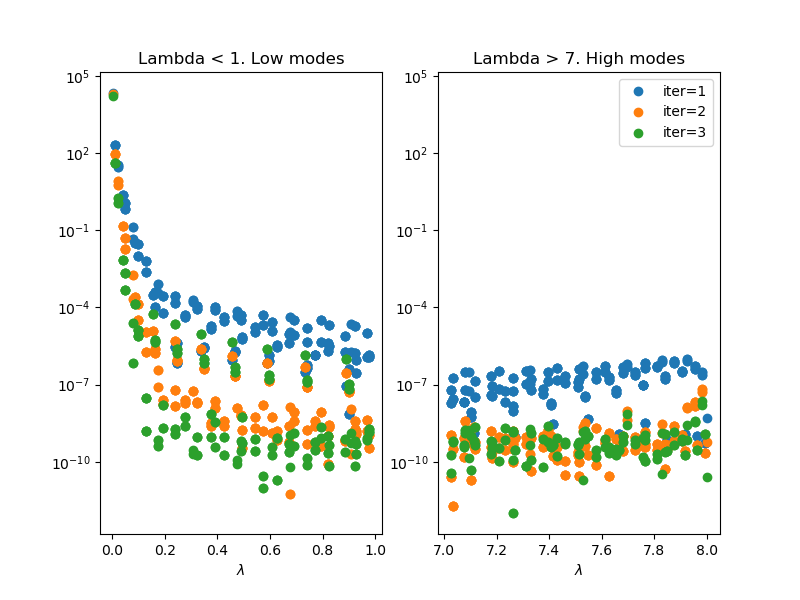

In [24]:
## Compare low and high modes

# fig,(ay1,ay2)= plt.subplots(ncols=2, sharey=True)
fig=plt.figure(figsize=(8,6))
plt.title("Fourier coefficients vs Lambda\n")
# Variation of fourier coefficients vs Lambda for small and large modes
# df=df1[(df1.ky<4)&(df1.kx<4)]
# # df=df1[(df1.ky>25)&(df1.kx>25)]
# df=df1[df1.Lambda>7]
plt.xticks([])
plt.yticks([])

ax1=plt.subplot(121)
df=df1[df1.Lambda<1]
for itr in iter_list:
    df2=df[df.iter==itr]
    plt.plot(df2.Lambda,df2.C,linestyle='',marker='o',label='iter='+str(itr))
ax1.set_title('Lambda < 1. Low modes')
plt.yscale('log')
plt.xlabel('Lambda')
plt.xlabel('$\lambda$')

ax2=plt.subplot(122,sharey=ax1)
# fig.add_subplot(1,2,2)
df=df1[df1.Lambda>7]
for itr in iter_list:
    df2=df[df.iter==itr]
    plt.plot(df2.Lambda,df2.C,linestyle='',marker='o',label='iter='+str(itr))
    
ax2.set_yticklabels([])
ax2.autoscale()
ax2.set_title('Lambda > 7. High modes')
plt.yscale('log')
plt.xlabel('$\lambda$')
plt.legend()
plt.show()

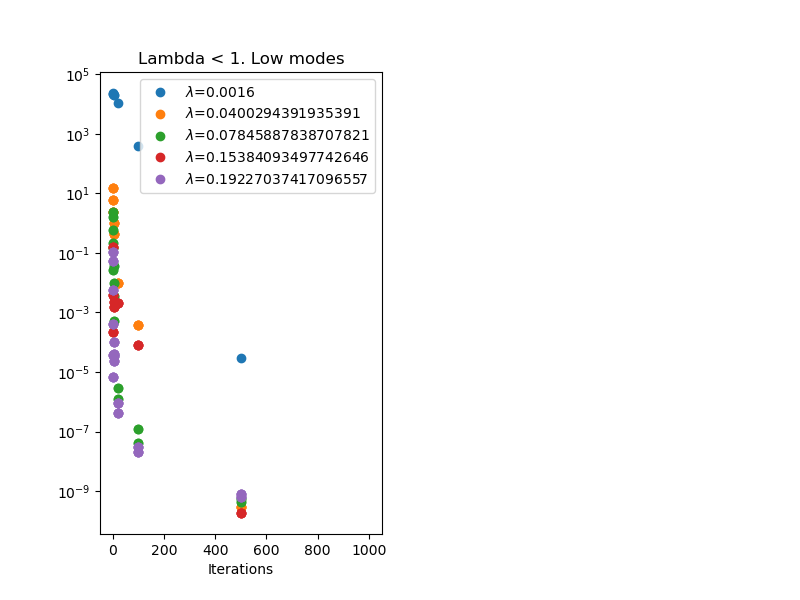

In [194]:
# Variation of different spectral values with iterations

## Compare low and high modes

# fig,(ay1,ay2)= plt.subplots(ncols=2, sharey=True)
fig=plt.figure(figsize=(8,6))
plt.title("Fourier coefficients vs iterations\n")
# Variation of fourier coefficients vs Lambda for small and large modes
plt.xticks([])
plt.yticks([])

ax1=plt.subplot(121)
# df=df1[df1.Lambda<1]
Lambda_list=np.unique(df1.Lambda.values)
# df=df1[df1.Lambda.isin(Lambda_list)]
df=df1[:]

for Lambda in Lambda_list[:5]:
    df2=df[df.Lambda==Lambda]
    plt.plot(df2.iter,df2.C,linestyle='',marker='o',label='$\lambda$='+str(Lambda))
ax1.set_title('Lambda < 1. Low modes')
plt.yscale('log')
plt.xlabel('Iterations')

# ax2=plt.subplot(122,sharey=ax1)
# fig.add_subplot(1,2,2)
# df=df1[df1.Lambda>7]
# for itr in iter_list:
#     df2=df[df.iter==itr]
#     plt.plot(df2.Lambda,df2.C,linestyle='',marker='o',label='iter='+str(itr))
    
ax2.set_yticklabels([])
ax2.autoscale()
ax2.set_title('Lambda > 7. High modes')
plt.yscale('log')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [195]:
print(df1[df1.iter==1].shape)
df1[df1.iter==1].groupby('Lambda').first()

(1024, 5)


,iter,kx,ky,C
Lambda,,,,
0.001600,1.0,0.0,0.0,23414.135268
0.040029,1.0,-1.0,0.0,15.522905
0.078459,1.0,-1.0,-1.0,2.434067
0.153841,1.0,-2.0,0.0,0.158691
0.192270,1.0,-2.0,-1.0,0.105747
...,...,...,...,...
7.810930,1.0,-15.0,-14.0,0.000018
7.849359,1.0,-16.0,-14.0,0.000012
7.924741,1.0,-15.0,-15.0,0.000011


### Check if solution is correct

$$ A = \phi_{x,y} \left( \phi_{x+1,y} + \phi_{x-1,y} + \phi_{x,y+1} + \phi_{x,y-1} - (4+m^2) \phi_{x,y} \right) $$

In [ ]:
L=32
# build A matrix
Amat=np.zeros((L**2,L**2),dtype=np.float32)
for x1 in range(L):
    for y1 in range(L):
        for x2 in range(L):
            for y2 in range(L):
                idx1=x1+y1*L; idx2=x2+y2*L;
                if (y1==y2):
                    if (np.abs(x1-x2)==1 or np.abs(x1-x2)==L-1): 
                        Amat[idx1,idx2]=1
                        # print("(%s,%s), (%s,%s), %s-%s"%(x1,y1,x2,y2,idx1,idx2))
                    elif (x1==x2): 
                        # print("(%s,%s), (%s,%s), %s-%s"%(x1,y1,x2,y2,idx1,idx2))
                        Amat[idx1,idx2]=-4.0-m**2
                if (x1==x2):
                    if (np.abs(y1-y2)==1 or np.abs(y1-y2)==L-1): 
                        # print("(%s,%s), (%s,%s), %s-%s"%(x1,y1,x2,y2,idx1,idx2))
                        Amat[idx1,idx2]=1
                        

In [ ]:
# for i in range(L**2):
#     for j in range(L**2): 
#         print(Amat[i,j],end='\t')
#     print('\n')

In [ ]:
spec=np.linalg.eigvals(-Amat)
print(spec)

In [ ]:
plt.figure()
_=plt.hist(spec,bins=21)

In [ ]:
# Convert solution to 1D array 
phi=np.zeros(L**2,dtype=float)
for x in range(L):
    for y in range(L):
        phi[x+y*L]=soln[x,y]
        
# Compute b = A.phi        
btemp=np.dot(Amat,phi)
# Reconvert back to 2D array
b_cal=np.empty((L,L),dtype=float)
for x in range(L):
    for y in range(L):
        b_cal[x,y]=btemp[x+y*L]

In [ ]:
b_cal[L//2,L//2],1.0/(4+m**2)

In [ ]:
for i in range(btemp.shape[0]):
    if btemp[i]>1e-3:
        print(i,btemp[i])